In [1]:
import os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageOps

import torch

import utils
from utils import ext_transforms as et

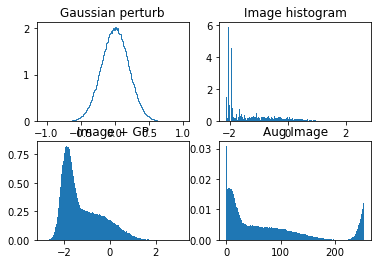

In [108]:
img = Image.open('/data1/sdi/datasets/CPN_all/Images/FH_I0000916_2.bmp').convert('RGB')
ma = Image.open('/data1/sdi/datasets/CPN_all/Masks/FH_I0000916_2_mask.bmp')

ext_trans = [ et.ExtToTensor(), 
                et.ExtNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                et.GaussianPerturb(mean=0, std=0.1) ]

def genImage(im):
    denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return (denorm(im.numpy()) * 255).transpose(1, 2, 0).astype(np.uint8)

pic, _ = ext_trans[0](img, img)
pic, _ = ext_trans[1](pic, _)
gp = np.random.normal(0, 0.2, np.shape(pic.numpy()))
tmp = pic + torch.from_numpy(gp)
pic2 = genImage(tmp)

fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(gp.flatten(), bins=255, density=True, align='mid', histtype='step')
axs[0, 0].set_title('Gaussian perturb')
axs[0, 1].hist(np.array(pic, dtype=np.float32).flatten(), bins=255, density=True, align='mid')
axs[0, 1].set_title('Image histogram')
axs[1, 0].hist(np.array(tmp, dtype=np.float32).flatten(), bins=255, density=True, align='mid')
axs[1, 0].set_title('Image + GP')
axs[1, 1].hist(genImage(tmp).flatten(), bins=[i for i in range(255)], density=True, align='mid')
axs[1, 1].set_title('Aug Image')
plt.show()

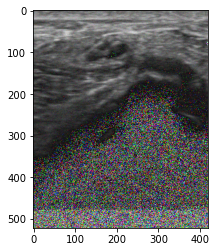

In [3]:
plt.imshow(pic2, )

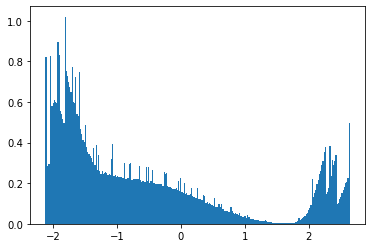

In [4]:
pic2 = genImage(tmp)
pic2, _ = ext_trans[0](pic2, img)
pic2, _ = ext_trans[1](pic2, _)
plt.hist(np.array(pic2, dtype=np.float32).flatten(), bins=255, density=True, align='mid')
plt.show()

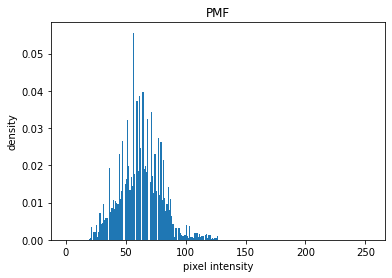

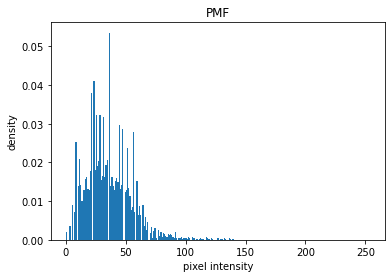

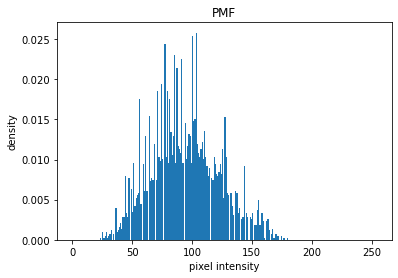

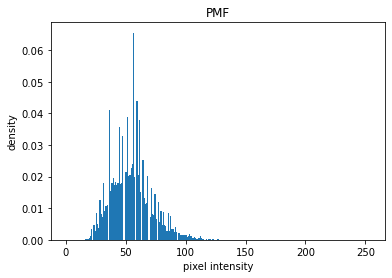

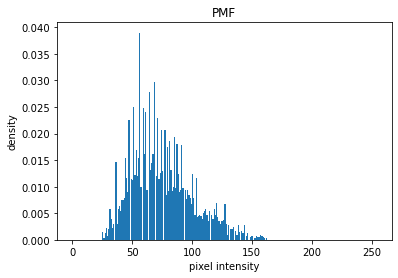

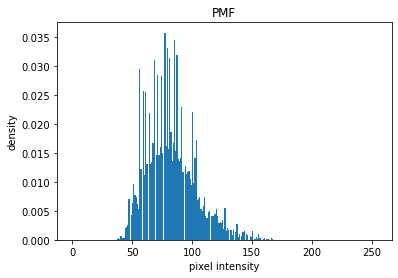

In [141]:
images = os.listdir('/data1/sdi/datasets/CPN_all/Images/')
cnt = 0

for fname in images:
    cnt += 1
    mname = fname.split('.')[0] + "_mask." + fname.split('.')[-1]
    mask = os.path.join('/data1/sdi/datasets/CPN_all/Masks', mname)
    image = os.path.join('/data1/sdi/datasets/CPN_all/Images', fname)

    if not os.path.exists(mask) or not os.path.exists(image):
        raise Exception ("File Not Exists", mask, image)
    
    image = Image.open(image).convert("L")
    mask = Image.open(mask).convert("L")

    plt.hist(np.array(image, dtype=np.uint8)[np.where(np.array(mask) > 0)].flatten(), bins=[i for i in range(255)], density=True, align='mid', histtype='bar')
    plt.title('PMF')
    plt.xlabel('pixel intensity')
    plt.ylabel('density')
    plt.savefig('/data1/sdi/PMF.png')
    plt.show()

    if cnt > 5:
        break
        
    

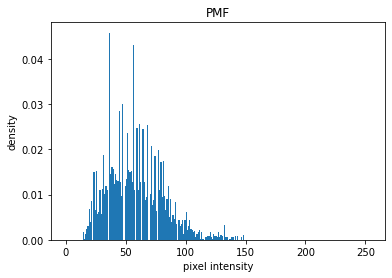

In [130]:
plt.hist(np.array(img, dtype=np.uint8)[np.where(np.array(ma) > 0)].flatten(), bins=[i for i in range(255)], density=True, align='mid', histtype='bar')
plt.title('PMF')
plt.xlabel('pixel intensity')
plt.ylabel('density')
#plt.savefig('/data1/sdi/PMF.png')
plt.show()

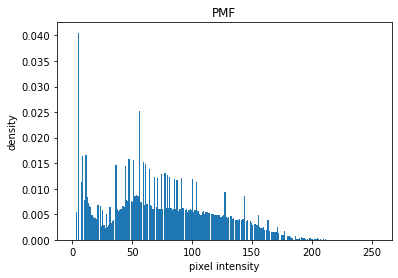

In [131]:
plt.hist(np.array(img, dtype=np.uint8)[0:300,0:300,:].flatten(), bins=[i for i in range(255)], density=True, align='mid', histtype='bar')
plt.title('PMF')
plt.xlabel('pixel intensity')
plt.ylabel('density')
#plt.savefig('/data1/sdi/PMF.png')
plt.show()

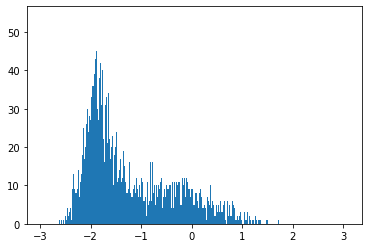

In [106]:
import numpy as np
from gmm import GMM

CLUSTER = 5
#data = np.random.normal(-5, 1, (500, 1))
#data_alpha = np.random.normal(5, 1, (500, 1))
#data = np.append(data, data_alpha).reshape((1000, 1))
data = np.array(tmp, dtype=np.float32).reshape((-1, 1))

plt.hist(data, bins=100000)
plt.show()

In [100]:
mm = GMM(C=CLUSTER)
mm.fit(data)

100%|██████████| 100/100 [7:44:58<00:00, 278.99s/it] 


0

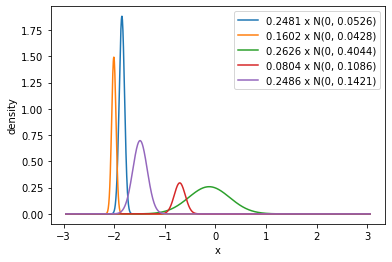

In [101]:
import matplotlib.pyplot as plt

x = np.arange(round(data.min(), 3), round(data.max(), 3), 0.005)

def gaussian(x, mean, sigma, pi):
    return pi * (1 / np.sqrt(2*np.pi * sigma**2)) * np.exp(- (x-mean)**2 / (2*sigma**2))

legend = []
for i in range(0, CLUSTER):
    pi = mm.parameters['pi'][i]
    mu = mm.parameters['mu'][i, 0]
    sigma = mm.parameters['sigma'][i, 0, 0]
    legend.append(f'{pi:.4f} x N(0, {sigma:.4f})')
    plt.plot(x, gaussian(x, mu, sigma, pi))

plt.xlabel('x')
plt.ylabel('density')
plt.legend(legend)
plt.show()

In [102]:
mm.parameters['mu']

array([[-1.84954882],
       [-2.00885996],
       [-0.12378937],
       [-0.70531978],
       [-1.49054159]])

In [103]:
mm.parameters['sigma']

array([[[0.05260948]],

       [[0.04282496]],

       [[0.40440687]],

       [[0.10857593]],

       [[0.14214313]]])

In [94]:
np.array(tmp, dtype=np.float32).reshape((-1, 1)).shape

(656154, 1)